<a href="https://colab.research.google.com/github/seungjun02/reinforcement-Learning/blob/main/chapter2/4_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 초기화
for 모든 s에 대하여 임의의 값으로 V(s) 가치함수와 Pi(s) 정책을 초기화함

2. 정책평가
while 정책이 수렴할 때까지 반복(오차가 theta 어떤 작은 값 보다 작아질때 종료)
  diff = 0
  
  for 모든 상태 s
    v = V(s)
    V(s) = sigma(s_next, r) (p(s_next, r | s, Pi(s))[r + gamma * V(s_next)])
    diff = max(diff, abs(v - V(s)))
  
  if diff < theta:
    break


3. 정책 향상
  안정적 정책 = True
  
  for 모든 상태 s
    이전상태 = Pi(s)
    
    Pi(s) = argmax(sigma(s_next, r) (p(s_next, r | s, Pi(s))[r + gamma * V(s_next)]))
    
    if 이전상태 != Pi(s)
      안정적 정책 = False

  if 안정적 정책 == True:
    return Pi(S), V(S)
    
  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

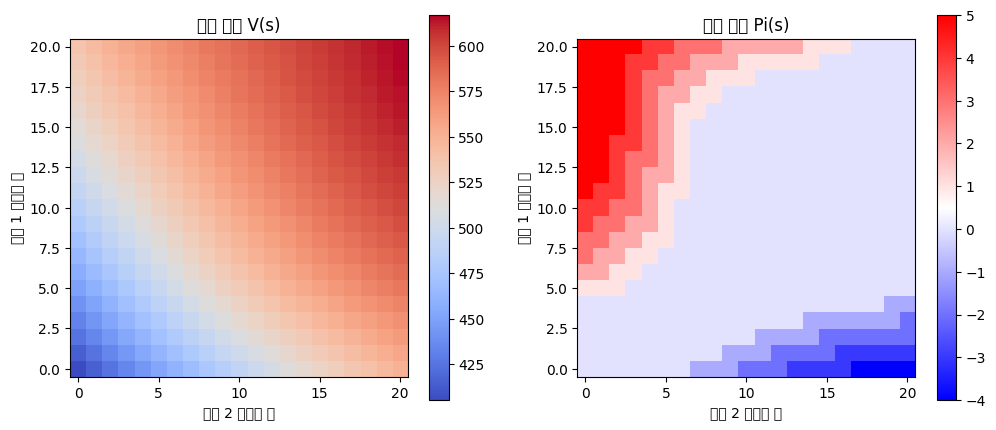

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

# 환경 변수 설정
MAX_CARS = 20  # 각 지점에서 보유할 수 있는 최대 자동차 대수
MAX_MOVE = 5  # 한 번에 이동할 수 있는 최대 자동차 대수
RENT_REWARD = 10  # 자동차를 빌려줄 때 받는 보상
MOVE_COST = 2  # 자동차를 이동할 때 드는 비용
GAMMA = 0.9  # 할인율
THETA = 1e-4  # 정책 평가 수렴 기준

# 푸아송 분포 계산 (요청 및 반납 확률 미리 저장)
poisson_cache = {}
def poisson_prob(n, lam):
    global poisson_cache
    key = (n, lam)
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

def expected_return(state, action, V):
    s1, s2 = state
    s1 -= action  # 자동차 이동 적용
    s2 += action
    s1 = min(max(s1, 0), MAX_CARS)
    s2 = min(max(s2, 0), MAX_CARS)

    reward = -MOVE_COST * abs(action)  # 이동 비용 반영
    total_value = 0.0

    for rental1 in range(11):  # 요청 최대값 제한
        for rental2 in range(11):
            prob_rental1 = poisson_prob(rental1, 3)
            prob_rental2 = poisson_prob(rental2, 4)

            real_rental1 = min(s1, rental1)
            real_rental2 = min(s2, rental2)

            reward_rent = (real_rental1 + real_rental2) * RENT_REWARD

            s1_next = s1 - real_rental1
            s2_next = s2 - real_rental2

            for return1 in range(11):
                for return2 in range(11):
                    prob_return1 = poisson_prob(return1, 3)
                    prob_return2 = poisson_prob(return2, 2)

                    s1_final = min(s1_next + return1, MAX_CARS)
                    s2_final = min(s2_next + return2, MAX_CARS)

                    prob = prob_rental1 * prob_rental2 * prob_return1 * prob_return2
                    total_value += prob * (reward_rent + GAMMA * V[s1_final, s2_final])

    return reward + total_value

# 정책 반복
V = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)

while True:
    # 정책 평가
    while True:
        delta = 0
        for s1 in range(MAX_CARS + 1):
            for s2 in range(MAX_CARS + 1):
                v = V[s1, s2]
                V[s1, s2] = expected_return((s1, s2), policy[s1, s2], V)
                delta = max(delta, abs(v - V[s1, s2]))
        if delta < THETA:
            break

    # 정책 향상
    policy_stable = True
    for s1 in range(MAX_CARS + 1):
        for s2 in range(MAX_CARS + 1):
            old_action = policy[s1, s2]
            action_returns = {}

            for action in range(-MAX_MOVE, MAX_MOVE + 1):
                if 0 <= s1 - action <= MAX_CARS and 0 <= s2 + action <= MAX_CARS:
                    action_returns[action] = expected_return((s1, s2), action, V)

            best_action = max(action_returns, key=action_returns.get)
            policy[s1, s2] = best_action
            if old_action != best_action:
                policy_stable = False

    if policy_stable:
        break

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
c1 = ax1.imshow(V, cmap="coolwarm", origin="lower")
fig.colorbar(c1, ax=ax1)
ax1.set_title("value function V(s)")
ax1.set_xlabel("spot 2 ")
ax1.set_ylabel("spot 1 ")

ax2 = axes[1]
c2 = ax2.imshow(policy, cmap="bwr", origin="lower")
fig.colorbar(c2, ax=ax2)
ax2.set_title("policy function Pi(s)")
ax2.set_xlabel("spot 2 ")
ax2.set_ylabel("spot 1 ")

plt.show()


변경사항 1 :  1-> 2 로 자동차를 옮기는 경우에 1대는 무료로 2달러를 지불하지 않고 옮길 수 있음

변경사항 2 : 각 지점의 주차 대수가 10대가 넘어갈시 4달러의 주차비용을 내야함

In [ ]:
import numpy as np
import scipy.stats as stats

# 환경 설정
MAX_CARS = 20  # 각 지점에서 보유 가능한 최대 자동차 대수
MOVE_LIMIT = 5  # 한 번에 이동 가능한 최대 차량 수
MOVE_COST = 2  # 차량 이동 비용 ($2 per car, except first free move for 1->2)
PARKING_COST = 4  # 주차 비용 (11대 이상일 경우)
RENTAL_REWARD = 10  # 렌트 시 차량당 보상
GAMMA = 0.9  # 할인율
THETA = 1e-4  # 정책 평가 수렴 기준

# 푸아송 분포 설정 (대여 및 회수율)
RENTAL_REQUESTS_1, RENTAL_REQUESTS_2 = 3, 4  # 지점별 대여 요청 평균
RETURNS_1, RETURNS_2 = 3, 2  # 지점별 반납 평균

poisson_cache = dict()

def poisson_prob(n, lam):
    """ 푸아송 분포 확률 계산 (캐싱) """
    global poisson_cache
    key = (n, lam)
    if key not in poisson_cache:
        poisson_cache[key] = stats.poisson.pmf(n, lam)
    return poisson_cache[key]

# 상태 공간, 정책, 가치 함수 초기화
states = [(i, j) for i in range(MAX_CARS + 1) for j in range(MAX_CARS + 1)]
policy = {s: 0 for s in states}
V = {s: 0.0 for s in states}

def expected_return(state, action, V):
    """ 주어진 상태(state)와 행동(action)에 대한 기대 보상을 계산 """
    s1, s2 = state
    new_s1 = min(s1 - action, MAX_CARS)  # 차량 이동 후 상태
    new_s2 = min(s2 + action, MAX_CARS)
    reward = 0

    # 이동 비용 반영
    if action > 0:  # 지점 1 -> 지점 2 이동 시 첫 대는 무료
        reward -= MOVE_COST * (abs(action) - 1)
    else:
        reward -= MOVE_COST * abs(action)

    # 주차 비용 반영
    if new_s1 > 10:
        reward -= PARKING_COST
    if new_s2 > 10:
        reward -= PARKING_COST

    expected_value = 0

    # 대여 및 반납을 고려한 상태 전이
    for rental_1 in range(0, new_s1 + 1):
        for rental_2 in range(0, new_s2 + 1):
            p_rental = poisson_prob(rental_1, RENTAL_REQUESTS_1) * poisson_prob(rental_2, RENTAL_REQUESTS_2)

            reward_rental = (rental_1 + rental_2) * RENTAL_REWARD
            remaining_s1 = new_s1 - rental_1
            remaining_s2 = new_s2 - rental_2

            for return_1 in range(MAX_CARS - remaining_s1 + 1):
                for return_2 in range(MAX_CARS - remaining_s2 + 1):
                    p_return = poisson_prob(return_1, RETURNS_1) * poisson_prob(return_2, RETURNS_2)
                    next_s1 = min(remaining_s1 + return_1, MAX_CARS)
                    next_s2 = min(remaining_s2 + return_2, MAX_CARS)

                    total_prob = p_rental * p_return
                    expected_value += total_prob * (reward_rental + GAMMA * V[(next_s1, next_s2)])

    return reward + expected_value

# 정책 반복 알고리즘
policy_stable = False
while not policy_stable:
    # 1. 정책 평가 (Policy Evaluation)
    while True:
        delta = 0
        for state in states:
            v = V[state]
            V[state] = expected_return(state, policy[state], V)
            delta = max(delta, abs(v - V[state]))
        if delta < THETA:
            break

    # 2. 정책 향상 (Policy Improvement)
    policy_stable = True
    for state in states:
        old_action = policy[state]
        action_returns = {}

        for action in range(-MOVE_LIMIT, MOVE_LIMIT + 1):
            if 0 <= state[0] - action <= MAX_CARS and 0 <= state[1] + action <= MAX_CARS:
                action_returns[action] = expected_return(state, action, V)

        best_action = max(action_returns, key=action_returns.get)
        policy[state] = best_action

        if old_action != best_action:
            policy_stable = False

# 결과 출력 (정책 및 가치 함수 시각화)
import matplotlib.pyplot as plt
import seaborn as sns

V_matrix = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
policy_matrix = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

for (s1, s2), v in V.items():
    V_matrix[s1, s2] = v
    policy_matrix[s1, s2] = policy[(s1, s2)]

plt.figure(figsize=(10, 5))
sns.heatmap(V_matrix, annot=False, cmap="coolwarm")
plt.title("Value Function (V)")
plt.xlabel("Cars at Location 2")
plt.ylabel("Cars at Location 1")
plt.show()

plt.figure(figsize=(10, 5))
sns.heatmap(policy_matrix, annot=False, cmap="coolwarm")
plt.title("Policy Function (Pi)")
plt.xlabel("Cars at Location 2")
plt.ylabel("Cars at Location 1")
plt.show()
